# Generación de un modelo a partir de uno modelo pre-entrenado
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [ ]:
MNT_DRIVE_DIR = '/content/drive/'
DRIVE_DIR = '/content/drive/MyDrive/'
DATOS_DIR = DRIVE_DIR + 'Datos/'
FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/Fuentes'

from google.colab import drive
drive.mount(MNT_DRIVE_DIR)

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


---
**Preparación de Dataset**

Para poder trabajar con el dataset se debe:
1. Copiar los archivos Espectros.7z.001, Espectros.7z.002 y Espectros.7z.003 en la carpeta drive de los datos (establecida para este script en DATOS_DIR).
2. Descomprimir con 7zip los archivos

In [ ]:
# Los archivos Fingers.7z.001, Fingers.7z.002 y Fingers.7z.003 deben estar en la carpeta
# para descomprimir las imagenes con el compresor 7zip
#!7z x "/content/drive/MyDrive/Datos/Fingers.7z.001" -o"/content/drive/MyDrive/Datos/"


**Construcción del Modelo**

Cargando imágenes:  100.00% (18657) 

Cargando imágenes:  100.00% (3968) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                               

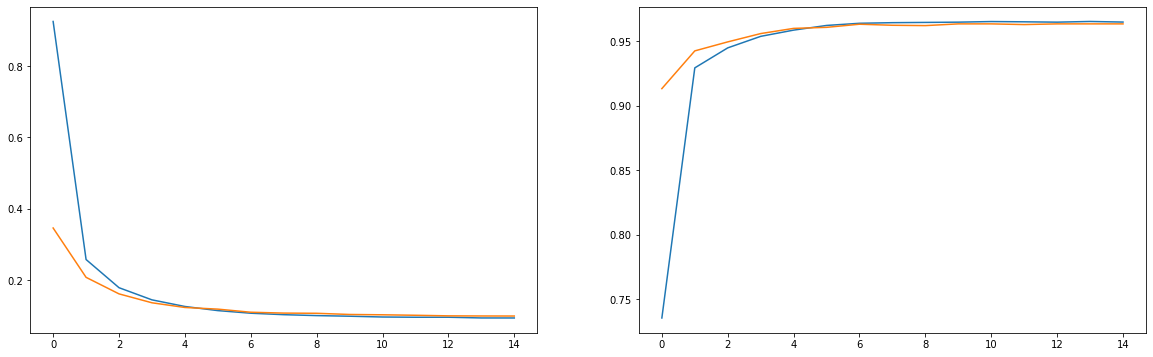

<Figure size 432x288 with 0 Axes>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import rotate
import numpy as np
import glob
import matplotlib.pyplot as plt


IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'

def import_data(img_list):
    img_data = []
    label_data = []
    
    img_count = len(img_list)
    for i in range(0,img_count):
        img = img_list[i]
        img_read = io.imread(img)
        img_read = img_read/img_read.max() # normaliza pixeles entre 0 y 1
        img_read = img_read.reshape((*img_read.shape,1)) # formatea imagen como requiere TF
        img_data.append(img_read)          # agrega a lista de imágenes a procesar
        label_data.append(img[-6])         # extrae cant. dedos del nombre del archivo
        # muestra progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes: %6.2f%%" % (100*i/img_count), end="")
    print("\rCargando imágenes:  100.00%% (%d) \n" % img_count)
        
    return np.array(img_data), np.array(label_data)

# %% Carga y procesa imagenes de entrenamiento y testeo

# lista de archivos a procesar
train_img_list = glob.glob(DATOS_DIR+"Fingers/train/*/*.png")
assert len(train_img_list) > 0, IMG_ERROR 

# carga las imagenes a partir de los nombres de archivos
xtrain, ytrain = import_data(train_img_list)

# lista de archivos a procesar
test_img_list = glob.glob(DATOS_DIR+"Fingers/test/*/*.png")

# carga las imagenes a partir de los nombres de archivos
xtest, ytest = import_data(test_img_list)

EPOCAS = 15
LOTES  = 50
IMG_SIZE = (64, 64, 1)
N_CLASSES = len(np.unique(ytrain))

# conviertes el id de la clase en "one hot encoding": 3 => [0,0,0,1,0,0]
ytest = to_categorical(ytest, num_classes = N_CLASSES)
ytrain = to_categorical(ytrain, num_classes = N_CLASSES)

# separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size = 0.20, shuffle = True)

# %% construye le modelo
def build_model(img_size, classes):
    model = Sequential()

    model.add(Input(shape=img_size))
    model.add(Conv2D(8, kernel_size=(3,3), strides=(2,2), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))  
    model.add(Conv2D(16, kernel_size=(3,3), strides=(2,2), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    model.add(Dense(10, activation = 'tanh'))
    model.add(Dense(classes, activation = 'softmax'))

    model.summary()
    return model

# obtiene la arquitectura para el modelo y lo compila
model = build_model(IMG_SIZE, N_CLASSES)
model.compile('adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
 

# entrena el modelo y guarda la historia del progreso    
H = model.fit(x = x_train, y = y_train, batch_size = LOTES, epochs = EPOCAS, validation_data = (x_val, y_val))

fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")


# %% evalua el modelo para entrenamiento
pred = model.evaluate(xtrain, ytrain, verbose=0)
print("\nEfectividad del modelo con datos de entrenamiento: %6.2f%%" % (pred[1]*100))

# evalua el modelo con los datos de testeo
pred = model.evaluate(xtest, ytest, verbose=0)
print("Efectividad del modelo con datos de Prueba.......: %6.2f%%" % (pred[1]*100))

---
**Prueba con Datos Modificados**

Prueba del modelo con ejemplos de datos "no vistos" durante el entrenamiento. En este caso los datos de prueba se encuentran rotados al azar entre -45 y 45 grados.


In [ ]:
from random import random


def rotar_al_azar(data_imgs, max_ang):
    result = np.zeros_like(data_imgs)
    for i,img in enumerate(data_imgs):
        ang = (random()-0.5)*max_ang
        result[i] = rotate(img, ang)

    return result


xtest_rot = rotar_al_azar(xtest, 45)

# evalua el modelo con los datos de testeo
pred = model.evaluate(xtest_rot, ytest, verbose=0)
print("Efectividad del modelo con datos de Prueba.......: %6.2f%%" % (pred[1]*100))


Efectividad del modelo con datos de Prueba.......:  79.16%
